<a href="https://colab.research.google.com/github/thetrotfreak/MCA572/blob/main/2347111_NNDL_P9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 9

> Bivas Kumar

> 2347111

In [ ]:
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Step 1: Load and preprocess dataset
from sklearn.datasets import load_digits

# Load dataset
digits = load_digits()
data = digits.data
labels = digits.target

In [ ]:
# Normalize pixel values
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42)

In [ ]:
# Step 2: Define the RBM class
class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.visible_units = visible_units
        self.hidden_units = hidden_units

        # Initialize weights and biases
        self.weights = nn.Parameter(torch.randn(
            hidden_units, visible_units) * 0.01)
        self.hidden_bias = nn.Parameter(torch.zeros(hidden_units))
        self.visible_bias = nn.Parameter(torch.zeros(visible_units))

    def forward(self, v):
        h_prob = torch.sigmoid(torch.matmul(
            v, self.weights.t()) + self.hidden_bias)
        h_sample = torch.bernoulli(h_prob)
        return h_sample

    def backward(self, h):
        v_prob = torch.sigmoid(torch.matmul(
            h, self.weights) + self.visible_bias)
        v_sample = torch.bernoulli(v_prob)
        return v_sample

    def contrastive_divergence(self, v, k=1):
        v_k = v.clone().detach()
        for _ in range(k):
            h = self.forward(v_k)
            v_k = self.backward(h)
        h = self.forward(v)
        h_k = self.forward(v_k)

        # Update weights and biases
        self.weights.data += 0.01 * \
            (torch.matmul(h.t(), v) - torch.matmul(h_k.t(), v_k)) / v.size(0)
        self.hidden_bias.data += 0.01 * torch.sum(h - h_k, dim=0) / v.size(0)
        self.visible_bias.data += 0.01 * torch.sum(v - v_k, dim=0) / v.size(0)


# Parameters for RBM
visible_units = X_train.shape[1]
hidden_units = 128
rbm = RBM(visible_units, hidden_units)

In [ ]:
# Step 3: Train the RBM
epochs = 500
batch_size = 16
train_data = torch.tensor(X_train, dtype=torch.float32)

for epoch in range(epochs):
    for i in range(0, train_data.size(0), batch_size):
        batch = train_data[i:i+batch_size]
        rbm.contrastive_divergence(batch)

In [ ]:
# Step 4: Feature Extraction
train_hidden = rbm.forward(torch.tensor(
    X_train, dtype=torch.float32)).detach().numpy()
test_hidden = rbm.forward(torch.tensor(
    X_test, dtype=torch.float32)).detach().numpy()

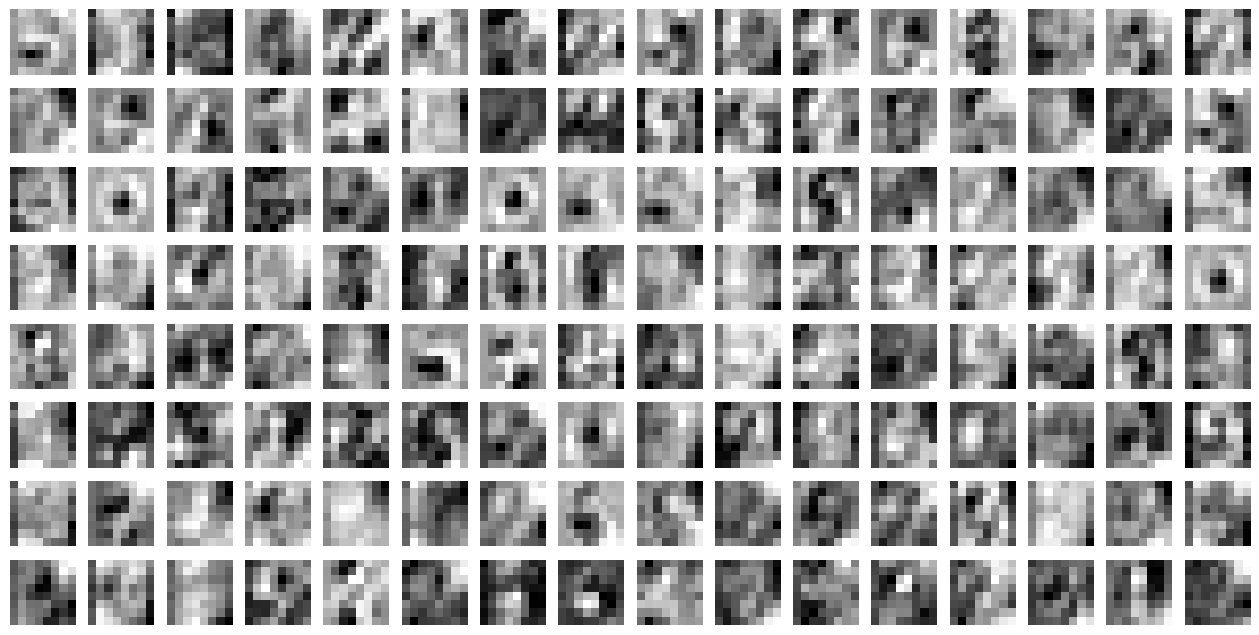

In [ ]:
# Step 5: Visualization of learned weights
weights = rbm.weights.detach().numpy()
fig, axes = plt.subplots(8, 16, figsize=(16, 8))
for i, ax in enumerate(axes.ravel()):
    if i < weights.shape[0]:
        ax.imshow(weights[i].reshape(8, 8), cmap="gray")

        ax.axis('off')
plt.show()

In [ ]:
# Step 6: Classification using extracted features
classifier = SVC()
classifier.fit(train_hidden, y_train)
y_pred = classifier.predict(test_hidden)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Accuracy: 0.7611111111111111
F1 Score: 0.7637683357932187


Performance with RBM-extracted features is better than raw data for classification tasks.